<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/NLP/Kaggle_movie_sentiment/Movies_review_sentiment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare X_train, y_train

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_path='/content/drive/My Drive/Data/NLP/Kaggle_movie_review_sentiment/train.tsv'
test_path='/content/drive/My Drive/Data/NLP/Kaggle_movie_review_sentiment/test.tsv'

In [ ]:
train_df=pd.read_csv(train_path,sep='\t')
print(train_df.shape)
train_df.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
train_df['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [ ]:
X=train_df['Phrase']
y=train_df['Sentiment']

In [ ]:
X

0         A series of escapades demonstrating the adage ...
1         A series of escapades demonstrating the adage ...
2                                                  A series
3                                                         A
4                                                    series
                                ...                        
156055                                            Hearst 's
156056                            forced avuncular chortles
156057                                   avuncular chortles
156058                                            avuncular
156059                                             chortles
Name: Phrase, Length: 156060, dtype: object

In [ ]:
y

0         1
1         2
2         2
3         2
4         2
         ..
156055    2
156056    1
156057    3
156058    2
156059    2
Name: Sentiment, Length: 156060, dtype: int64

In [ ]:
test_df=pd.read_csv(test_path,sep='\t')
print(test_df.shape)
test_df.head()

(66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


Text have no label, so we split training set to train and text set

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,
                                               stratify=y,random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(109242,)
(109242,)
(46818,)
(46818,)


In [ ]:
y_train.value_counts(normalize=True)

2    0.509950
3    0.210990
1    0.174759
4    0.058988
0    0.045312
Name: Sentiment, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

2    0.509932
3    0.210987
1    0.174762
4    0.058994
0    0.045324
Name: Sentiment, dtype: float64

# Text Classification chap 8 Twitter_Sentiment analysis Orelilly NLP

In [ ]:
#!pip install text_normalizer

In [ ]:
!pip install demoji

In [ ]:
'''
Contains helper funtions for preprocessing of twitter documents before getting their corresponding vectors
from word2vec_twitter model
Author: Anuj Gupta
'''

'''
functionality:
Discard non-english tweets
Discard Replies
Discard RTs
For now this is handle while fetch tweet text from mongo documents
process constantbrands mentions
process any other mentions
process constant brand name if any 
process hanstags
process URLs
process websites
process process_EmailIds
process 
process alphanums
'''

import re
import string
import demoji
demoji.download_codes()
from nltk.tokenize import TweetTokenizer

#gobal
PunctChars = r'''[`'“".?!,:;]'''
Punct = '%s+' % PunctChars
Entity = '&(amp|lt|gt|quot);'
printable = set(string.printable)

# helper functoins
def regex_or(*items):
	r = '|'.join(items)
	r = '(' + r + ')'
	return r

def pos_lookahead(r):
	return '(?=' + r + ')'

def neg_lookahead(r):
	return '(?!' + r + ')'

def optional(r):
	return '(%s)?' % r

def trim(transient_tweet_text):
	''' 
	trim leading and trailing spaces in the tweet text
	'''
	return transient_tweet_text.strip()

def strip_whiteSpaces(transient_tweet_text):
	'''
	Strip all white spaces
	'''
	transient_tweet_text = re.sub(r'[\s]+', ' ', transient_tweet_text)
	return transient_tweet_text

def to_LowerCase(transient_tweet_text):
	'''
	Convert tweet text to lower to lower case alphabets
	'''
	transient_tweet_text = transient_tweet_text.lower()
	return transient_tweet_text

def prune_multple_consecutive_same_char(transient_tweet_text):
	'''
	yesssssssss  is converted to yess 
	ssssssssssh is converted to ssh
	'''
	transient_tweet_text = re.sub(r'(.)\1+', r'\1\1', transient_tweet_text)
	return transient_tweet_text

def remove_spl_words(transient_tweet_text):
	transient_tweet_text = transient_tweet_text.replace('&amp;',' and ')

	return transient_tweet_text

def strip_unicode(transient_tweet_text):
    '''
    Strip all unicode characters from a tweet
    '''
    tweet = ''.join(i for i in transient_tweet_text if ord(i)<128)
    return tweet 

def process_URLs(transient_tweet_text):
	'''
	replace all URLs in the tweet text
	'''
	UrlStart1 = regex_or('https?://', r'www\.',r'bit.ly/')
	CommonTLDs = regex_or('com','co\\.uk','org','net','info','ca','biz','info','edu','in','au')
	UrlStart2 = r'[a-z0-9\.-]+?' + r'\.' + CommonTLDs + pos_lookahead(r'[/ \W\b]')
	UrlBody = r'[^ \t\r\n<>]*?'  # * not + for case of:  "go to bla.com." -- don't want period
	UrlExtraCrapBeforeEnd = '%s+?' % regex_or(PunctChars, Entity)
	UrlEnd = regex_or( r'\.\.+', r'[<>]', r'\s', '$')
	Url = 	(optional(r'\b') + 
    		regex_or(UrlStart1, UrlStart2) + 
    		UrlBody + 
    pos_lookahead( optional(UrlExtraCrapBeforeEnd) + UrlEnd))

	Url_RE = re.compile("(%s)" % Url, re.U|re.I)
	transient_tweet_text = re.sub(Url_RE, " constanturl ", transient_tweet_text)

	# fix to handle unicodes in URL
	URL_regex2 = r'\b(htt)[p\:\/]*([\\x\\u][a-z0-9]*)*'
	transient_tweet_text = re.sub(URL_regex2, " constanturl ", transient_tweet_text)
	return transient_tweet_text

def process_Websites(transient_tweet_text):
	'''
	identify website mentioned if any 
	'''
	CommonTLDs = regex_or('com','co\\.uk','org','net','info','ca','biz','info','edu','in','au')
	sep = r'[.]'
	website_regex = r'(?<!#)?(\b)?[a-zA-Z0-9.]+' + sep + CommonTLDs
	website_RE = re.compile("(%s)" % website_regex, re.U|re.I)
	transient_tweet_text = re.sub(website_RE, ' constantwebsite ', transient_tweet_text)

	return transient_tweet_text

def process_EmailIds(transient_tweet_text):
	'''
	identify email mentioned if any
	'''
	email_regex = r'(\b)?[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}(\b)?'
	transient_tweet_text = re.sub(email_regex, ' constantemailid ', transient_tweet_text)

	return transient_tweet_text

def process_Mentions(transient_tweet_text):
	'''
	Identify mentions if any
	'''
	transient_tweet_text = re.sub(r"@(\w+)", " constantnonbrandmention ", transient_tweet_text)
	return transient_tweet_text
def process_HashTags(transient_tweet_text):
	'''
	Strip all Hashtags from a tweet
	'''
	transient_tweet_text = re.sub(r"#(\w+)\b", ' constanthashtag ', transient_tweet_text)
	return transient_tweet_text

def process_Dates(transient_tweet_text):
	'''
	Identify date and convert it to constant
	'''
	#transient_tweet_text = re.sub(r'(\d+/\d+/\d+)', " constantdate " , transient_tweet_text)
	#transient_tweet_text = re.sub(r'constantnum[\s]?(/|-)[\s]?constantnum[\s]?(/|-)[\s]?constantnum', " constantdate " , transient_tweet_text)
	#date_regex = r'(constantnum)[\s]*(st|nd|rd|th)[\s]*(january|jan|february|feb|march|mar|april|may|june|jun|july|august|aug|september|sep|october|oct|november|nov|december|dec)'
	date_regex1 = r'\b((0|1|2|3)?[0-9][\s]*)[-./]([\s]*([012]?[0-9])[\s]*)([-./]([\s]*(19|20)[0-9][0-9]))?\b'
	transient_tweet_text = re.sub(date_regex1, ' constantdate ' , transient_tweet_text)
	date_regex2 = r'\b((19|20)[0-9][0-9][\s]*[-./]?)?[\s]*([012]?[0-9])[\s]*[-./][\s]*(0|1|2|3)?[0-9]\b'
	transient_tweet_text = re.sub(date_regex2, ' constantdate ' , transient_tweet_text)

	Months = regex_or('january','jan','february','feb','march','mar','april','may','june','jun','july','jul','august','aug','september','sep','october','oct','november','nov','december','dec')
	date_regex3 = r'\d+[\s]*(st|nd|rd|th)[\s]*' + Months 
	transient_tweet_text = re.sub(date_regex3, ' constantdate ', transient_tweet_text)
	date_regex4 = Months + r'[\s]*\d+[\s]*(st|nd|rd|th)*\b'
	transient_tweet_text = re.sub(date_regex4, ' constantdate ' , transient_tweet_text)
	date_regex5 = r'[\s]?\b(19|20)[0-9][0-9]\b[\s]?'
	transient_tweet_text = re.sub(date_regex5, ' constantdate ' , transient_tweet_text)

	date_regex6 = r'([\s]*(constantdate))+'
	transient_tweet_text = re.sub(date_regex6, ' constantdate ' , transient_tweet_text)

	return transient_tweet_text

def process_Times(transient_tweet_text):
	'''
	Indentify time and convert it to constant
	'''
	time_regex1 = r'([0-9]|0[0-9]|1[0-9]|2[0-3]):[0-5][0-9][\s]*(am|pm)?[\s]*([iescm](st)|gmt|utc|[pmce](dt))?'
	transient_tweet_text = re.sub(time_regex1, ' constanttime ' , transient_tweet_text)

	return transient_tweet_text

def process_BrandMentions(transient_tweet_text):
	'''
	process all airrwoot brands Mentions if any in tweet text
	'''
	constant_brands = regex_or('paytmcare', 'paytm','snapdeal_help','snapdeal','bluestone_com','shopohelp','shopo','mobikwikswat',
		'mobikwik','taxiforsure','tfscares','zoomcarindia','freshmenuindia','freshmenucares','grofers','jetairways',
		'cleartrip','olacabs','support_ola','makemytrip','makemytripcare','chai_point')

	BrandMentionRegex = r'@(\b)*' + constant_brands
	transient_tweet_text = re.sub(BrandMentionRegex, ' constantbrandmention ', transient_tweet_text)
	return transient_tweet_text

def process_NonBrandMentions(transient_tweet_text):
	'''
	process all Mentions left, if any, in tweet text
	'''
	transient_tweet_text = re.sub(r"@(\w+)", ' constantnonbrandmention ', transient_tweet_text)
	return transient_tweet_text

def process_BrandName(transient_tweet_text):
	'''
	process all airrwoot brands Mentions if any in tweet text
	'''
	constant_brands = regex_or('paytmcare', 'paytm','snapdeal_help','snapdeal','bluestone_com', 'bluestone','shopohelp','shopo',
		'mobikwikswat','mobikwik','taxiforsure','tfscares', 'tfs','zoomcarindia', 'zoomcar','freshmenuindia','freshmenucares', 
		'freshmenu','grofers','jetairways', 'jet','cleartrip','olacabs','support_ola', 'olacab', 'ola' ,'makemytrip',
		'makemytripcare', 'chai_point')

	BrandNameRegex = constant_brands
	transient_tweet_text = re.sub(BrandNameRegex, ' constantbrandname ', transient_tweet_text)
	return transient_tweet_text

def identify_Savings(transient_tweet_text):
	'''
	identify sale/save offers
	'''
	#sale_regex = r'(?<!#)\b(discount|discounts|sale|save|saver|super[\s]*saver|super[\s]*save)\b[\s]*(constantnum)*[\s]*[%]?[\s]*(-|~)?[\s]*(constantnum)*[\s]*[%]?'
	sale_regex = r'(?<!#)\b(discount|discounts|sale|save|saver|super[\s]*saver|super[\s]*save)\b[\s]*((rs|\$)*[\s]*(constantnum))*[\s]*[%]?[\s]*(-|~|or)?[\s]*((rs|\$)*[\s]*(constantnum))*[\s]*[%]?'
	transient_tweet_text = re.sub(sale_regex, " constantdiscount ", transient_tweet_text)
	#discount_List = []
	#discount_List = re.findall(r'constantdiscount', transient_tweet_text)
	return transient_tweet_text

def indentify_Offers(transient_tweet_text):
	'''
	identify cashbacks and off / substrings of the form "30% off" or "30% cashback" or "$30 off"
	Replace them by constantOFFER
	'''
	#transient_tweet_text = re.sub(r'[rs|$]?[ ]*[constantnum][ ]*[%]?[ ]?[off|cashback|offer]', "constantoffer", transient_tweet_text)
	transient_tweet_text = re.sub(r'(?<!#)\b(?:(up[\s]?to)?((rs|\$)*[\s]*(constantnum))[\s]*[%]?)?[\s]*[-|~|or]?[\.]?[\s]*((rs|\$)*[\s]*(constantnum))*[\s]*[%]?[\s]*(offer|off|cashback|cash|cash back)', " constantoffer ", transient_tweet_text)
	transient_tweet_text = re.sub(r'(?<!#)\b(?:cashback|cash back|cash)\b', " constantoffer ", transient_tweet_text)
	#Offer_List = []
	#Offer_List = re.findall(r'constantoffer', transient_tweet_text)
	return transient_tweet_text

def indentify_Promos(transient_tweet_text):
	'''
	indentify coupons/promos with promo codes
	Assumption - promo code can be alphanumeric. But it immediately follows text of promo/code/promocode etc
	'''
	#transient_tweet_text = re.sub(r'\b(promocode|promo code|promo|code)[s]?[\s]*[a-z]*(constantnum)*[a-z]*[\s]+', " constantpromo ", transient_tweet_text)
	transient_tweet_text = re.sub(r'(?<!#)\b(?:promocode|promo code|promo|coupon code|code)\b[\s]*(constantalphanum)\b', " constantpromo ", transient_tweet_text)
	transient_tweet_text = re.sub(r'(?<!#)\b(?:promocode|promo code|promo|coupon code|code)\b[\s]*[a-z]+\b', " constantpromo ", transient_tweet_text)
	transient_tweet_text = re.sub(r'(?<!#)\b(?:promocode|promo code|promo|coupon code|code)\b[\s]*[0-9]+\b', " constantpromo ", transient_tweet_text)
	transient_tweet_text = re.sub(r'(?<!#)\b(?:promocode|promo code|promo|coupon code|code|coupon)[s]?\b', " constantpromo ", transient_tweet_text)
	#Promo_List = []
	#Promo_List = re.findall(r'constantpromo', transient_tweet_text)
	return transient_tweet_text

def indentify_Money(transient_tweet_text):
	'''
	identify money in the tweet text but outside offers. This includes $,Rs, pound, Euro
	'''
	money_regex1 = r'\b(rs|\$)[\s]*(constantnum)?[\.]?[\s]*constantnum\b'
	transient_tweet_text = re.sub(money_regex1, " constantmoney ", transient_tweet_text)
	money_regex2 = r'[\s]*[\.]?[\s]*constantnum(cent[s]?|\$|c)\b'
	transient_tweet_text = re.sub(money_regex2, " constantmoney ", transient_tweet_text)
	money_regex3 = r'(\$|rs)[\s]*constantalphanum'
	transient_tweet_text = re.sub(money_regex3, " constantmoney ", transient_tweet_text)
	#Money_List = []
	#Money_List = re.findall(r'constantmoney', transient_tweet_text)
	return transient_tweet_text

def indentify_freebies(transient_tweet_text):
	'''
	indentify freebies in tweets if any - free offers, free shipping, free trial, 
	'''
	freebies_regex1 = r'(?<!#)\b(?:free)[\s]+[a-z]+\b'
	transient_tweet_text = re.sub(freebies_regex1, " constantfreebies ", transient_tweet_text)
	freebies_regex2 = r'(?<!#)\b(?:free)[\s]+[a-z]*\b'
	transient_tweet_text = re.sub(freebies_regex2, " constantfreebies ", transient_tweet_text)
	return transient_tweet_text

def replace_numbers(transient_tweet_text):
	'''
	Given any number/interger in tweet text, we want it to be replaced by constantnum
	'''
	# we want to process only those numbers that are not in a hashtag - below logic does this
	num_regex = r'(?<!#)\b(?:[-+]?[\d,]*[\.]?[\d,]*[\d]+|\d+)\b'
	transient_tweet_text = re.sub(num_regex, " constantnum " , transient_tweet_text)
	return transient_tweet_text

def identify_AlphaNumerics(transient_tweet_text):
	'''
	Identify alpha numerics - this helps in identifying product codes/models, promocodes, Order IDs
	'''
	AlphaNumeric_regex = r'(?<!#)\b(?:([a-z]+[0-9]+[a-z]*|[a-z]*[0-9]+[a-z]+)[a-z,0-9]*)\b'
	transient_tweet_text = re.sub(AlphaNumeric_regex, " constantalphanum ", transient_tweet_text)
	return transient_tweet_text

def strip_whiteSpaces(transient_tweet_text):
	'''
	Strip all white spaces
	'''
	transient_tweet_text = re.sub(r'[\s]+', ' ', transient_tweet_text)
	return transient_tweet_text

def prune_multple_consecutive_same_char(transient_tweet_text):
	'''
	yesssssssss  is converted to yess 
	ssssssssssh is converted to ssh
	'''
	transient_tweet_text = re.sub(r'(.)\1+', r'\1\1', transient_tweet_text)
	return transient_tweet_text

def remove_spl_words(transient_tweet_text):
	transient_tweet_text = transient_tweet_text.replace('&amp;',' and ')

	return transient_tweet_text

def remove_emoji(transient_tweet_text):
    tweet_tokenizer = TweetTokenizer()
    tokenized_tweet = tweet_tokenizer.tokenize(transient_tweet_text)
    emojis_present = demoji.findall(transient_tweet_text)
    tweet_no_emoji=''
    for i,s in enumerate(tokenized_tweet):
        if s in emojis_present.keys():
            tweet_no_emoji = tweet_no_emoji + ' ' + emojis_present[s]
        else:
            tweet_no_emoji = tweet_no_emoji + ' ' + s
    return tweet_no_emoji

def deEmojify(transient_tweet_text):
    return transient_tweet_text.encode('ascii', 'ignore').decode('ascii')

# def print_test():
    
#     test_tweet = "Nice @varun paytm @paytm saver abc@gmail.com sizes for the wolf on 20/10/2010 at 10:00PM  grey/deep royal-volt Nike Air Skylon II retro are 40% OFF for a limited time at $59.99 + FREE shipping.BUY HERE -> https://bit.ly/2L2n7rB (promotion - use code MEMDAYSV at checkout)"
#     #General Proprocessing
#     test_tweet = test_tweet.lower()
#     test_tweet = strip_unicode(test_tweet)
    
#     #function tests
#     print("Process URLS:\n",process_URLs(test_tweet))
#     print("Remove websites:\n",process_Websites(test_tweet))
#     print("Remove mentions:\n",process_Mentions(test_tweet))
#     print('Remove Emailid:\n',process_EmailIds(test_tweet))
#     print("Remove Hashtags:\n",process_HashTags(test_tweet))
#     print("Remove Dates:\n",process_Dates(test_tweet))
#     print("Process Time:\n",process_Times(test_tweet))
#     print("Process Brand Mention:\n",process_BrandMentions(test_tweet))
#     print("Process non Brand Mention:\n",process_NonBrandMentions(test_tweet))
#     print("Process Brand Name:\n",process_BrandName(test_tweet))
#     print("Process Savings:\n",identify_Savings(test_tweet))
#     print("Process Offers:\n",indentify_Offers(test_tweet))
#     print("Identiy Promos:\n",indentify_Promos(test_tweet))
# ############
# print_test()




def process_TweetText(tweet_text):
	'''
	Takes tweet_text and preprocesses it 
	Order of preprocessing:
	'''

	# get utf-8 encoding, lowercase, trim and remove multiple white spaces
	transient_tweet_text = tweet_text
	transient_tweet_text = strip_unicode(transient_tweet_text)
	#print "PROCESSED: ", transient_tweet_text

	transient_tweet_text = to_LowerCase(transient_tweet_text)
	transient_tweet_text = trim(transient_tweet_text)
	transient_tweet_text = strip_whiteSpaces(transient_tweet_text)
	transient_tweet_text = remove_spl_words(transient_tweet_text)

 
	#emoji
	transient_tweet_text = remove_emoji(transient_tweet_text) 
	transient_tweet_text = deEmojify(transient_tweet_text)
	# process Hastags, URLs, Websites, process_EmailIds
	# Give precedence to url over hashtag
	transient_tweet_text = process_URLs(transient_tweet_text)
	transient_tweet_text = process_HashTags(transient_tweet_text)
	#transient_tweet_text = process_Websites(transient_tweet_text)
	transient_tweet_text = process_EmailIds(transient_tweet_text)

	# process for brand mention, any other mention and brand Name
	#transient_tweet_text = process_BrandMentions(transient_tweet_text)
	#transient_tweet_text = process_NonBrandMentions(transient_tweet_text)
	transient_tweet_text = process_Mentions(transient_tweet_text)
	#transient_tweet_text = process_BrandName(transient_tweet_text)

	# remove any unicodes
	transient_tweet_text = strip_unicode(transient_tweet_text)

	# identify Date / Time if any
	transient_tweet_text = process_Times(transient_tweet_text)
	transient_tweet_text = process_Dates(transient_tweet_text)

	# indentify alphanums and nums
	transient_tweet_text = identify_AlphaNumerics(transient_tweet_text)
	transient_tweet_text = replace_numbers(transient_tweet_text)
	
	# identify promos, savings, offers, money and freebies
	transient_tweet_text = indentify_Promos(transient_tweet_text)
	transient_tweet_text = identify_Savings(transient_tweet_text)
	transient_tweet_text = indentify_Offers(transient_tweet_text)
	transient_tweet_text = indentify_Money(transient_tweet_text)
	transient_tweet_text = indentify_freebies(transient_tweet_text)

	transient_tweet_text = trim(transient_tweet_text)
	transient_tweet_text = strip_whiteSpaces(transient_tweet_text)

	transient_tweet_text = prune_multple_consecutive_same_char(transient_tweet_text)

	return transient_tweet_text

# if __name__ == "__main__":
# print(process_TweetText("Nice @varun paytm @paytm saver abc@gmail.com sizes for the wolf on 20/10/2010 at 10:00PM  grey/deep royal-volt Nike Air Skylon II retro are 40% OFF for a limited time at $59.99 + FREE shipping.BUY HERE -> https://bit.ly/2L2n7rB (promotion - use code MEMDAYSV at checkout)"))

... OK (Got response in 0.26 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [ ]:
#Making the necessary imports
import os
import sys

#preprocessing_path = "/home/etherealenvy/Downloads/practical-nlp/Ch8/O5_smtd_preprocessing.py"
#sys.path.append(os.path.abspath(preprocessing_path))

#import O5_smtd_preprocessing

from nltk.corpus import stopwords
from string import punctuation
import nltk
nltk.download('stopwords')

import pandas as pd
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')

from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()


#imports related to modeling
import numpy as np
from gensim.models import Word2Vec, KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
X_train_df=pd.DataFrame(X_train)
X_train_df

,Phrase
150238,make you wish you were at home watching that m...
133360,", the tale has turned from sweet to bitterswee..."
49191,can say that about most of the flicks moving i...
137709,"Does n't deliver a great story ,"
73297,unrecoverable life
...,...
142974,"Laced with liberal doses of dark humor , gorge..."
78231,Offers absolutely nothing I had n't already se...
7375,Ivan is a prince of a fellow
115288,the stomach-knotting suspense


In [ ]:
X_train_df['Phrase'].values

array(['make you wish you were at home watching that movie instead of in the theater watching this one',
       ', the tale has turned from sweet to bittersweet , and when the tears come during that final , beautiful scene , they finally feel absolutely earned .',
       'can say that about most of the flicks moving in and out of the multiplex',
       ..., 'Ivan is a prince of a fellow',
       'the stomach-knotting suspense', 'Quirky'], dtype=object)

In [ ]:
y_train

150238    1
133360    4
49191     2
137709    1
73297     1
         ..
142974    4
78231     1
7375      3
115288    3
2467      2
Name: Sentiment, Length: 109242, dtype: int64

In [ ]:
X_train_df['Phrase_process'] = X_train_df['Phrase'].apply(lambda x: process_TweetText(x))

In [ ]:
X_train_df.head()

,Phrase,Phrase_process
150238,make you wish you were at home watching that m...,make you wish you were at home watching that m...
133360,", the tale has turned from sweet to bitterswee...",", the tale has turned from sweet to bitterswee..."
49191,can say that about most of the flicks moving i...,can say that about most of the flicks moving i...
137709,"Does n't deliver a great story ,","does n't deliver a great story ,"
73297,unrecoverable life,unrecoverable life


In [ ]:
X_train_df['phrase_tokens'] = X_train_df['Phrase_process'].apply(lambda x: tweet_tokenizer.tokenize(x))
X_train_df['phrase_no_stopwords'] = X_train_df['phrase_tokens'].apply(lambda x: [word for word in x if word not in stopwords.words('english')])

In [ ]:
X_train_df.head()

,Phrase,Phrase_process,phrase_tokens,phrase_no_stopwords
150238,make you wish you were at home watching that m...,make you wish you were at home watching that m...,"[make, you, wish, you, were, at, home, watchin...","[make, wish, home, watching, movie, instead, t..."
133360,", the tale has turned from sweet to bitterswee...",", the tale has turned from sweet to bitterswee...","[,, the, tale, has, turned, from, sweet, to, b...","[,, tale, turned, sweet, bittersweet, ,, tears..."
49191,can say that about most of the flicks moving i...,can say that about most of the flicks moving i...,"[can, say, that, about, most, of, the, flicks,...","[say, flicks, moving, multiplex]"
137709,"Does n't deliver a great story ,","does n't deliver a great story ,","[does, n't, deliver, a, great, story, ,]","[n't, deliver, great, story, ,]"
73297,unrecoverable life,unrecoverable life,"[unrecoverable, life]","[unrecoverable, life]"


## Train your own Embedding

In [ ]:
phrase_processed=X_train_df['Phrase_process'].values

In [ ]:
#CBOW
import time
start = time.time()
w2v_model = Word2Vec(phrase_processed,min_count=5, sg=0)
end = time.time()
print("CBOW Model Training Complete.\nTime taken for training is:{:.5f} sec ".format((end-start)))

CBOW Model Training Complete.
Time taken for training is:7.45960 sec 


In [ ]:
#Create document vectors by averaging word vectors.
def embedding_feats(list_of_lists):
    DIMENSION = 100
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this +=1
        feats.append(feat_for_this/count_for_this if count_for_this > 0 else feat_for_this)        
    return feats

train_vectors = embedding_feats(X_train_df['phrase_no_stopwords'].values)
print(len(train_vectors))

109242


In [ ]:
#Take any classifier (LogisticRegression here)
classifier = LogisticRegression(random_state=2020)
classifier.fit(train_vectors, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2020, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
X_test_df=pd.DataFrame(X_test)
X_test_df['Phrase_process'] = X_test_df['Phrase'].apply(lambda x: process_TweetText(x))
X_test_df['phrase_tokens'] = X_test_df['Phrase_process'].apply(lambda x: tweet_tokenizer.tokenize(x))
X_test_df['phrase_no_stopwords'] = X_test_df['phrase_tokens'].apply(lambda x: [word for word in x if word not in stopwords.words('english')])
X_test_df.head()


,Phrase,Phrase_process,phrase_tokens,phrase_no_stopwords
105687,"seems just as expectant of an adoring , wide-s...","seems just as expectant of an adoring , wide-s...","[seems, just, as, expectant, of, an, adoring, ...","[seems, expectant, adoring, ,, wide-smiling, r..."
133291,"the dream world of teen life ,","the dream world of teen life ,","[the, dream, world, of, teen, life, ,]","[dream, world, teen, life, ,]"
36948,purpose and finesse,purpose and finesse,"[purpose, and, finesse]","[purpose, finesse]"
101915,"Argento , at only 26","argento , at only constantnum","[argento, ,, at, only, constantnum]","[argento, ,, constantnum]"
150567,you may ask,you may ask,"[you, may, ask]","[may, ask]"


In [ ]:
phrase_processed=X_test_df['Phrase_process'].values
#CBOW
import time
start = time.time()
w2v_model = Word2Vec(phrase_processed,min_count=5, sg=0)
end = time.time()
print("CBOW Model Training Complete.\nTime taken for training is:{:.5f} sec ".format((end-start)))

CBOW Model Training Complete.
Time taken for training is:3.24631 sec 


In [ ]:
test_vectors = embedding_feats(X_test_df['phrase_no_stopwords'].values)
print(len(test_vectors))

46818


In [ ]:
preds = classifier.predict(test_vectors)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.10      0.13      0.12      2122
           1       0.19      0.13      0.15      8182
           2       0.53      0.84      0.65     23874
           3       0.18      0.02      0.03      9878
           4       0.00      0.00      0.00      2762

    accuracy                           0.46     46818
   macro avg       0.20      0.22      0.19     46818
weighted avg       0.35      0.46      0.37     46818



# Deep learning (Chap 4 classification Oreillly NLP)

## Prepare data

In [ ]:

#Make the necessary imports
import os
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model, Sequential
from keras.initializers import Constant

In [ ]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

In [ ]:
train_path='/content/drive/My Drive/Data/NLP/Kaggle_movie_review_sentiment/train.tsv'
test_path='/content/drive/My Drive/Data/NLP/Kaggle_movie_review_sentiment/test.tsv'

In [ ]:
train_df=pd.read_csv(train_path,sep='\t')
print(train_df.shape)
train_df.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
X=train_df['Phrase']
y=train_df['Sentiment']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,
                                               stratify=y,random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(109242,)
(109242,)
(46818,)
(46818,)


## 1. Tokenize the texts and convert them into word index vectors

In [ ]:
X_train.values

array(['make you wish you were at home watching that movie instead of in the theater watching this one',
       ', the tale has turned from sweet to bittersweet , and when the tears come during that final , beautiful scene , they finally feel absolutely earned .',
       'can say that about most of the flicks moving in and out of the multiplex',
       ..., 'Ivan is a prince of a fellow',
       'the stomach-knotting suspense', 'Quirky'], dtype=object)

In [ ]:
#Vectorize these text samples into a 2D integer tensor using Keras Tokenizer
#Tokenizer is fit on training data only, and that is used to tokenize both train and test data.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS) #20000
tokenizer.fit_on_texts(X_train.values)
train_sequences = tokenizer.texts_to_sequences(X_train.values) #Converting text to a vector of word indexes
test_sequences = tokenizer.texts_to_sequences(X_test.values)
word_index = tokenizer.word_index #(X_train, luc nay chua phan ra X_train_new va X_valid)
print('Found %s unique tokens.' % len(word_index))
# max 20000 words keep in sequences, word index is just a show case, not use (> max words)

Found 15264 unique tokens.


In [ ]:
print(train_sequences[0]) # max 10000 words in sequences
print(len(train_sequences[0]))

[77, 22, 970, 22, 175, 30, 448, 227, 9, 17, 378, 3, 7, 1, 317, 227, 18, 26]
18



## 2. Pad the text sequences so that all text vectors are of the same length.

In [ ]:
#Converting this to sequences to be fed into neural network. Max seq. len is 1000 as set earlier
#initial padding of 0s, until vector is of size MAX_SEQUENCE_LENGTH
train_sequences_padding = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH) #1000
test_sequences_padding = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH) #1000

In [ ]:
#Before transform
print(len(train_sequences)) # train_texts --> train_sequences
print(len(train_sequences[0]))
print(train_sequences[0])

109242
18
[77, 22, 970, 22, 175, 30, 448, 227, 9, 17, 378, 3, 7, 1, 317, 227, 18, 26]


In [ ]:
#After transform
print(train_sequences_padding.shape)
train_sequences_padding

(109242, 1000)


array([[   0,    0,    0, ...,  227,   18,   26],
       [   0,    0,    0, ...,  140, 1487, 3657],
       [   0,    0,    0, ...,    3,    1, 4473],
       ...,
       [   0,    0,    0, ...,    3,    2, 2915],
       [   0,    0,    0, ..., 1308, 9589,  436],
       [   0,    0,    0, ...,    0,    0,  429]], dtype=int32)

In [ ]:
train_labels = to_categorical(np.asarray(y_train))
test_labels = to_categorical(np.asarray(y_test))

print(y_train[:3])
print(train_labels.shape)
train_labels

150238    1
133360    4
49191     2
Name: Sentiment, dtype: int64
(109242, 5)


array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

## Split the training data into a training set and a validation set

In [ ]:
X_test=test_sequences_padding
y_test=test_labels
print(X_test.shape)
print(y_test.shape)

(46818, 1000)
(46818, 5)


In [ ]:
X_train_new,X_valid,y_train_new,y_valid=train_test_split(train_sequences_padding,train_labels,
                                                         test_size=0.3,
                                               stratify=train_labels,random_state=42)
print(X_train_new.shape)
print(y_train_new.shape)
print(X_valid.shape)
print(y_valid.shape)

(76469, 1000)
(76469, 5)
(32773, 1000)
(32773, 5)


##3. Map every word index to an embedding vector (for pre-train model| can skip if no need pre train)

In [ ]:
print('Preparing embedding matrix.')

# first, build index mapping words in the embeddings set
# to their embedding vector
embeddings_index = {}
with open('/content/drive/My Drive/Data/NLP/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0] # vocabulary name
        coefs = np.asarray(values[1:], dtype='float32') # embedding 100 dim
        embeddings_index[word] = coefs

print('Found %s word vectors in Glove embeddings.' % len(embeddings_index))
print(embeddings_index["google"])
print(len(embeddings_index["google"]))
print(MAX_NUM_WORDS)
print(EMBEDDING_DIM)

Preparing embedding matrix.
Found 400000 word vectors in Glove embeddings.
[ 0.22575  -0.56253  -0.05156  -0.079389  1.1876   -0.48397  -0.23342
 -0.85278   0.97495  -0.33344   0.71692   0.12644   0.31962  -1.4136
 -0.57903  -0.037286 -0.0164    0.45155  -0.29005   0.52599  -0.22534
 -0.29556  -0.032407  1.5608   -0.013499 -0.064558  0.26625   0.78595
 -0.71693  -0.93025   0.80461   1.6035   -0.30602  -0.34764   0.93872
  0.38137  -0.26743  -0.56519   0.58899  -0.14554  -0.34324   0.21291
 -0.39887   0.090042 -0.8495    0.38803  -0.5045   -0.22488   1.0644
 -0.2624    1.0334    0.06348  -0.39989   0.24236  -0.65636  -1.8107
 -0.061801  0.13795   1.1658   -0.30046  -0.50143   0.16509   0.039835
  0.62541   0.56935   0.64125   0.21308   0.30276   0.39673   0.38973
  0.28183   0.79481  -0.11962  -0.49598  -0.53195  -0.14897   0.51254
 -0.39208  -0.58535  -0.078509  0.81721  -0.73497  -0.68131   0.099243
 -0.87608   0.029632  0.33402  -0.14305   0.16964  -0.035178  0.39777
  0.71769   0.25

In [ ]:
# prepare embedding matrix - rows are the words from word_index, columns are the embeddings of that word from glove.
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
print(num_words)
print(embedding_matrix.shape)
print(len(word_index)) # max 20000 tu hay gap nhat thoi, index nay khong xai het
print(len(embeddings_index))

15265
(15265, 100)
15264
400000


In [ ]:
for word, i in word_index.items():
    if i > MAX_NUM_WORDS: # chi thuc hien get embedding word < max_num_words(20000)
        continue
    embedding_vector = embeddings_index.get(word) #lay 100d embedding cho tung tu
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
print(embedding_matrix.shape)
embedding_matrix[1]

(15265, 100)


array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

In [ ]:
labels_index=len(np.unique(y))
labels_index

5

## Build model

## Keras

In [ ]:
# y_test = test_sequences_padding

### 1D CNN Model with pre-trained embedding

In [ ]:
# load these pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(input_dim=num_words,#15265 (max 20000)
                            output_dim=EMBEDDING_DIM, #100
                            embeddings_initializer=Constant(embedding_matrix), #(15265, 100)
                            input_length=MAX_SEQUENCE_LENGTH, #1000
                            trainable=False)
print("Preparing of embedding matrix is done")

Preparing of embedding matrix is done


In [ ]:
labels_index=len(np.unique(y))
labels_index

5

In [ ]:
print('Define a 1D CNN model.')

cnnmodel = Sequential()
cnnmodel.add(embedding_layer)
cnnmodel.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(GlobalMaxPooling1D())
cnnmodel.add(Dense(128, activation='relu'))
cnnmodel.add(Dense(labels_index, activation='softmax'))

cnnmodel.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
cnnmodel.summary()

Define a 1D CNN model.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         1526500   
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
global_max_pooling1d (Global (N

In [ ]:
#Train the model. Tune to validation set. 
cnnmodel.fit(X_train_new, y_train_new,
          batch_size=200,
          epochs=1, validation_data=(X_valid, y_valid))

383/383 [==============================] - 22s 59ms/step - loss: 1.1060 - acc: 0.5578 - val_loss: 1.0369 - val_acc: 0.5784


In [ ]:
#Evaluate on test set:
score, acc = cnnmodel.evaluate(test_sequences_padding, test_labels)
print('Test accuracy with CNN:', acc)

1464/1464 [==============================] - 10s 7ms/step - loss: 1.0420 - acc: 0.5764
Test accuracy with CNN: 0.5764449834823608


In [ ]:
y_pred=cnnmodel.predict_classes(test_sequences_padding)
y_pred

array([2, 2, 2, ..., 1, 2, 2])

In [ ]:
test_labels_reverse=np.argmax(test_labels, axis =1)
test_labels_reverse

array([1, 2, 3, ..., 3, 2, 2])

In [ ]:
print(classification_report(test_labels_reverse,y_pred))

              precision    recall  f1-score   support

           0       0.28      0.35      0.31      2122
           1       0.39      0.26      0.31      8182
           2       0.65      0.85      0.74     23874
           3       0.51      0.36      0.42      9878
           4       0.66      0.09      0.15      2762

    accuracy                           0.58     46818
   macro avg       0.50      0.38      0.39     46818
weighted avg       0.56      0.58      0.54     46818



### 1D CNN model with training your own embedding¶

In [ ]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

In [ ]:

print("Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings")
cnnmodel2 = Sequential()
cnnmodel2.add(Embedding(MAX_NUM_WORDS, 128)) # co the thieu input length = MAX_SEQUENCE_LENGTH (1000)
cnnmodel2.add(Conv1D(128, 5, activation='relu'))
cnnmodel2.add(MaxPooling1D(5))
cnnmodel2.add(Conv1D(128, 5, activation='relu'))
cnnmodel2.add(MaxPooling1D(5))
cnnmodel2.add(Conv1D(128, 5, activation='relu'))
cnnmodel2.add(GlobalMaxPooling1D())
cnnmodel2.add(Dense(128, activation='relu'))
cnnmodel2.add(Dense(labels_index, activation='softmax'))

cnnmodel2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
print(cnnmodel2.summary())

Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 128)         82048     
_________

In [ ]:
#Train the model. Tune to validation set. 
cnnmodel2.fit(X_train_new, y_train_new,
          batch_size=200, #75000 X_train shape
          epochs=1, validation_data=(X_valid, y_valid))

383/383 [==============================] - 41s 107ms/step - loss: 1.1858 - acc: 0.5329 - val_loss: 1.0873 - val_acc: 0.5795


In [ ]:
#Evaluate on test set:
y_pred=cnnmodel2.predict_classes(test_sequences_padding)
test_labels_reverse=np.argmax(test_labels, axis =1)
print(classification_report(test_labels_reverse,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2122
           1       0.40      0.22      0.29      8182
           2       0.63      0.87      0.73     23874
           3       0.47      0.40      0.43      9878
           4       0.49      0.15      0.23      2762

    accuracy                           0.58     46818
   macro avg       0.40      0.33      0.34     46818
weighted avg       0.52      0.58      0.53     46818



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LSTM Model with training your own embedding

In [ ]:
print("Defining and training an LSTM model, training embedding layer on the fly")

#model
rnnmodel = Sequential()
rnnmodel.add(Embedding(MAX_NUM_WORDS, 128))
rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
rnnmodel.add(Dense(labels_index, activation='sigmoid'))
rnnmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
rnnmodel.summary()

Defining and training an LSTM model, training embedding layer on the fly
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 2,692,229
Trainable params: 2,692,229
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train the model. Tune to validation set. 
rnnmodel.fit(X_train_new, y_train_new,
          batch_size=200, #75000 X_train shape
          epochs=1, validation_data=(X_valid, y_valid))
#  1472s 4s/step - loss: 0.3740 - accuracy: 0.5546 - val_loss: 0.3232 - val_accuracy: 0.6187
#Evaluate on test set:
y_pred=rnnmodel.predict_classes(test_sequences_padding)
test_labels_reverse=np.argmax(test_labels, axis =1)
print(classification_report(test_labels_reverse,y_pred))

383/383 [==============================] - 1472s 4s/step - loss: 0.3740 - accuracy: 0.5546 - val_loss: 0.3232 - val_accuracy: 0.6187
              precision    recall  f1-score   support

           0       0.43      0.01      0.01      2122
           1       0.50      0.38      0.43      8182
           2       0.70      0.83      0.76     23874
           3       0.49      0.59      0.53      9878
           4       0.59      0.05      0.09      2762

    accuracy                           0.62     46818
   macro avg       0.54      0.37      0.37     46818
weighted avg       0.60      0.62      0.58     46818



### LSTM Model using pre-trained Embedding Layer

In [ ]:

print("Defining and training an LSTM model, using pre-trained embedding layer")

rnnmodel2 = Sequential()
rnnmodel2.add(embedding_layer)
rnnmodel2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
rnnmodel2.add(Dense(labels_index, activation='sigmoid'))
rnnmodel2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(rnnmodel2.summary())

Defining and training an LSTM model, using pre-trained embedding layer
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         1526500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 1,644,393
Trainable params: 117,893
Non-trainable params: 1,526,500
_________________________________________________________________
None


In [ ]:
#Train the model. Tune to validation set. 
rnnmodel2.fit(X_train_new, y_train_new,
          batch_size=200, #75000 X_train shape
          epochs=1, validation_data=(X_valid, y_valid))
#Evaluate on test set:
y_pred=rnnmodel2.predict_classes(test_sequences_padding)
test_labels_reverse=np.argmax(test_labels, axis =1)
print(classification_report(test_labels_reverse,y_pred))

383/383 [==============================] - 1357s 4s/step - loss: 0.3639 - accuracy: 0.5577 - val_loss: 0.3349 - val_accuracy: 0.5898
              precision    recall  f1-score   support

           0       0.38      0.01      0.02      2122
           1       0.44      0.27      0.33      8182
           2       0.67      0.84      0.74     23874
           3       0.46      0.53      0.49      9878
           4       0.52      0.06      0.11      2762

    accuracy                           0.59     46818
   macro avg       0.49      0.34      0.34     46818
weighted avg       0.56      0.59      0.55     46818



- DL model is better than ML model. (improve 20% macro and weighted avg, 10% accuracy)
- RNN model is better than CNN model, but very long time training (~ 20 times lower), accuracy is not imporve so much (just 4%)

# BERT

In [2]:
# install BERT
!pip install pytorch_pretrained_bert pytorch-nlp

     |████████████████████████████████| 133kB 4.7MB/s 
     |████████████████████████████████| 92kB 8.3MB/s 


In [3]:
#importing a few necessary packages and setting the DATA directory
DATA_DIR="."
import os
import numpy as np
import pickle
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore") 
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

In [4]:
train_path='/content/drive/My Drive/Data/NLP/Kaggle_movie_review_sentiment/train.tsv'
train_df=pd.read_csv(train_path,sep='\t')
print(train_df.shape)
train_df.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
train_df=train_df[['Phrase','Sentiment']]
train_df.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


In [6]:
X=train_df['Phrase']
y=train_df['Sentiment']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,
                                               stratify=y,random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(109242,)
(109242,)
(46818,)
(46818,)


In [7]:
X_train

150238    make you wish you were at home watching that m...
133360    , the tale has turned from sweet to bitterswee...
49191     can say that about most of the flicks moving i...
137709                     Does n't deliver a great story ,
73297                                    unrecoverable life
                                ...                        
142974    Laced with liberal doses of dark humor , gorge...
78231     Offers absolutely nothing I had n't already se...
7375                           Ivan is a prince of a fellow
115288                        the stomach-knotting suspense
2467                                                 Quirky
Name: Phrase, Length: 109242, dtype: object

In [8]:
#cleaning the text
from bs4 import BeautifulSoup
import re

def strip(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub('\[[^]]*\]', '', soup.get_text())
    pattern=r"[^a-zA-z0-9\s,']"
    text=re.sub(pattern,'',text)
    return text

X_train=X_train.apply(strip)

In [9]:
X_train

150238    make you wish you were at home watching that m...
133360    , the tale has turned from sweet to bitterswee...
49191     can say that about most of the flicks moving i...
137709                     Does n't deliver a great story ,
73297                                    unrecoverable life
                                ...                        
142974    Laced with liberal doses of dark humor , gorge...
78231     Offers absolutely nothing I had n't already seen 
7375                           Ivan is a prince of a fellow
115288                         the stomachknotting suspense
2467                                                 Quirky
Name: Phrase, Length: 109242, dtype: object

In [10]:
#BERT needs to understand 2 things:
#1) The start and end of each sentiment
# so we declare a special token CLS which tells BERT that its a classification task
sentences = X_train
sentence = ["[CLS] "+i+" [SEP]" for i in sentences]

In [11]:
sentence[0]

'[CLS] make you wish you were at home watching that movie instead of in the theater watching this one [SEP]'

In [12]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Restricting the max size of Tokens to 512(BERT doest accept any more than this)
tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:510] , sentence))

100%|██████████| 231508/231508 [00:00<00:00, 883968.76B/s]


In [13]:
print (sentence[0])
print (tokenized_texts[0])
print(len(tokenized_texts[0]))
print (sentence[1])
print (tokenized_texts[1])
print(len(tokenized_texts[1]))

[CLS] make you wish you were at home watching that movie instead of in the theater watching this one [SEP]
['[CLS]', 'make', 'you', 'wish', 'you', 'were', 'at', 'home', 'watching', 'that', 'movie', 'instead', 'of', 'in', 'the', 'theater', 'watching', 'this', 'one', '[SEP]']
20
[CLS] , the tale has turned from sweet to bittersweet , and when the tears come during that final , beautiful scene , they finally feel absolutely earned  [SEP]
['[CLS]', ',', 'the', 'tale', 'has', 'turned', 'from', 'sweet', 'to', 'bitter', '##sw', '##eet', ',', 'and', 'when', 'the', 'tears', 'come', 'during', 'that', 'final', ',', 'beautiful', 'scene', ',', 'they', 'finally', 'feel', 'absolutely', 'earned', '[SEP]']
31


In [14]:
labels = list(y_train)#storing the labels
#print(labels)

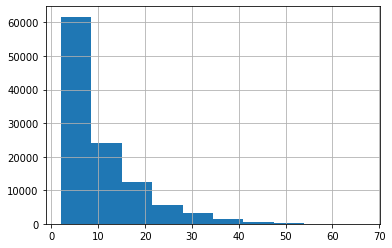

In [15]:
len_toeknized = pd.Series(list(map(lambda t: len(t) , tokenized_texts)))
len_toeknized.hist()

In [16]:
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
print(input_ids[0])

[101, 2191, 2017, 4299, 2017, 2020, 2012, 2188, 3666, 2008, 3185, 2612, 1997, 1999, 1996, 4258, 3666, 2023, 2028, 102]


In [17]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
print(input_ids.shape)
input_ids

(109242, 128)


array([[  101,  2191,  2017, ...,     0,     0,     0],
       [  101,  1010,  1996, ...,     0,     0,     0],
       [  101,  2064,  2360, ...,     0,     0,     0],
       ...,
       [  101,  7332,  2003, ...,     0,     0,     0],
       [  101,  1996,  4308, ...,     0,     0,     0],
       [  101, 21864, 15952, ...,     0,     0,     0]])

BERT is a MLM(Masked Language Model). We have to define its mask.

In [18]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [19]:
# Select a batch size for training. 
batch_size = 20

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [20]:
num_labels=len(set(labels))
num_labels

5

In [ ]:
#Loading pre trained BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=num_labels)#multi classification
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [ ]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

torch.cuda.empty_cache() 
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.8056901631144803


Epoch:  25%|██▌       | 1/4 [51:34<2:34:44, 3094.77s/it]

Validation Accuracy: 0.6957952468007317


t_total value of -1 results in schedule not being applied

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]Train loss: 0.8056901631144803

Epoch:  25%|██▌       | 1/4 [51:34<2:34:44, 3094.77s/it]Validation Accuracy: 0.6957952468007317

Evaluate test data

In [ ]:
# load test data
X_test=X_test.apply(strip)
sentences = X_test
sentence = ["[CLS] "+i+" [SEP]" for i in sentences]
labels = list(y_test)#

# tokenize test data
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# create test tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
batch_size = 32  
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Prediction on test set
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []
for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)
  
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))


# Pytorch (not complete)

## Prepare Data

LSTM pytorch

In [ ]:
#library imports
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
torch.manual_seed(0)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model, Sequential
from keras.initializers import Constant
import pandas as pd
import numpy as np
import re
from collections import Counter
import string
from sklearn.metrics import mean_squared_error,accuracy_score

In [ ]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

In [ ]:
train_path='/content/drive/My Drive/Data/NLP/Kaggle_movie_review_sentiment/train.tsv'
test_path='/content/drive/My Drive/Data/NLP/Kaggle_movie_review_sentiment/test.tsv'

In [ ]:
train_df=pd.read_csv(train_path,sep='\t')
print(train_df.shape)
train_df.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
X=train_df['Phrase']
y=train_df['Sentiment']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,
                                               stratify=y,random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(109242,)
(109242,)
(46818,)
(46818,)


In [ ]:
#Vectorize these text samples into a 2D integer tensor using Keras Tokenizer
#Tokenizer is fit on training data only, and that is used to tokenize both train and test data.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS) #20000
tokenizer.fit_on_texts(X_train.values)
train_sequences = tokenizer.texts_to_sequences(X_train.values) #Converting text to a vector of word indexes
test_sequences = tokenizer.texts_to_sequences(X_test.values)
word_index = tokenizer.word_index #(X_train, luc nay chua phan ra X_train_new va X_valid)
print('Found %s unique tokens.' % len(word_index))
# max 20000 words keep in sequences, word index is just a show case, not use (> max words)

Found 15264 unique tokens.


In [ ]:
print(train_sequences[0]) # max 10000 words in sequences
print(len(train_sequences[0]))

[77, 22, 970, 22, 175, 30, 448, 227, 9, 17, 378, 3, 7, 1, 317, 227, 18, 26]
18


In [ ]:
#Converting this to sequences to be fed into neural network. Max seq. len is 1000 as set earlier
#initial padding of 0s, until vector is of size MAX_SEQUENCE_LENGTH
train_sequences_padding = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH) #1000
test_sequences_padding = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH) #1000

In [ ]:
#Before transform
print(len(train_sequences)) # train_texts --> train_sequences
print(len(train_sequences[0]))
print(train_sequences[0])

109242
18
[77, 22, 970, 22, 175, 30, 448, 227, 9, 17, 378, 3, 7, 1, 317, 227, 18, 26]


In [ ]:
#After transform
print(train_sequences_padding.shape)
train_sequences_padding

(109242, 1000)


array([[   0,    0,    0, ...,  227,   18,   26],
       [   0,    0,    0, ...,  140, 1487, 3657],
       [   0,    0,    0, ...,    3,    1, 4473],
       ...,
       [   0,    0,    0, ...,    3,    2, 2915],
       [   0,    0,    0, ..., 1308, 9589,  436],
       [   0,    0,    0, ...,    0,    0,  429]], dtype=int32)

In [ ]:
train_labels = to_categorical(np.asarray(y_train))
test_labels = to_categorical(np.asarray(y_test))

print(y_train[:3])
print(train_labels.shape)
train_labels

150238    1
133360    4
49191     2
Name: Sentiment, dtype: int64
(109242, 5)


array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
X_train_new,X_valid,y_train_new,y_valid=train_test_split(train_sequences_padding,train_labels,
                                                         test_size=0.3,
                                               stratify=train_labels,random_state=42)
print(X_train_new.shape)
print(y_train_new.shape)
print(X_valid.shape)
print(y_valid.shape)

(76469, 1000)
(76469, 5)
(32773, 1000)
(32773, 5)


In [ ]:
X_test=test_sequences_padding
y_test=test_labels
print(X_test.shape)
print(y_test.shape)

(46818, 1000)
(46818, 5)


In [ ]:
print('Preparing embedding matrix.')

# first, build index mapping words in the embeddings set
# to their embedding vector
embeddings_index = {}
with open('/content/drive/My Drive/Data/NLP/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0] # vocabulary name
        coefs = np.asarray(values[1:], dtype='float32') # embedding 100 dim
        embeddings_index[word] = coefs

print('Found %s word vectors in Glove embeddings.' % len(embeddings_index))
print(embeddings_index["google"])
print(len(embeddings_index["google"]))
print(MAX_NUM_WORDS)
print(EMBEDDING_DIM)

Preparing embedding matrix.
Found 400000 word vectors in Glove embeddings.
[ 0.22575  -0.56253  -0.05156  -0.079389  1.1876   -0.48397  -0.23342
 -0.85278   0.97495  -0.33344   0.71692   0.12644   0.31962  -1.4136
 -0.57903  -0.037286 -0.0164    0.45155  -0.29005   0.52599  -0.22534
 -0.29556  -0.032407  1.5608   -0.013499 -0.064558  0.26625   0.78595
 -0.71693  -0.93025   0.80461   1.6035   -0.30602  -0.34764   0.93872
  0.38137  -0.26743  -0.56519   0.58899  -0.14554  -0.34324   0.21291
 -0.39887   0.090042 -0.8495    0.38803  -0.5045   -0.22488   1.0644
 -0.2624    1.0334    0.06348  -0.39989   0.24236  -0.65636  -1.8107
 -0.061801  0.13795   1.1658   -0.30046  -0.50143   0.16509   0.039835
  0.62541   0.56935   0.64125   0.21308   0.30276   0.39673   0.38973
  0.28183   0.79481  -0.11962  -0.49598  -0.53195  -0.14897   0.51254
 -0.39208  -0.58535  -0.078509  0.81721  -0.73497  -0.68131   0.099243
 -0.87608   0.029632  0.33402  -0.14305   0.16964  -0.035178  0.39777
  0.71769   0.25

In [ ]:
# prepare embedding matrix - rows are the words from word_index, columns are the embeddings of that word from glove.
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
print(num_words)
print(embedding_matrix.shape)
print(len(word_index)) # max 20000 tu hay gap nhat thoi, index nay khong xai het
print(len(embeddings_index))

15265
(15265, 100)
15264
400000


In [ ]:
for word, i in word_index.items():
    if i > MAX_NUM_WORDS: # chi thuc hien get embedding word < max_num_words(20000)
        continue
    embedding_vector = embeddings_index.get(word) #lay 100d embedding cho tung tu
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
print(embedding_matrix.shape)
embedding_matrix[1]

(15265, 100)


array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

In [ ]:
labels_index=len(np.unique(y))
labels_index

5

## Model

In [ ]:
# load these pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(input_dim=num_words,#15265 (max 20000)
                            output_dim=EMBEDDING_DIM, #100
                            embeddings_initializer=Constant(embedding_matrix), #(15265, 100)
                            input_length=MAX_SEQUENCE_LENGTH, #1000
                            trainable=False)
print("Preparing of embedding matrix is done")

Preparing of embedding matrix is done


In [ ]:
labels_index

5

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, n_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, labels_index)
        
    def forward(self, x):
        out = self.embedding(x)
        out, _ = self.lstm(out)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.output(out)
        out = out[-1,0]
        out = torch.sigmoid(out).unsqueeze(0)
        
        return out

In [ ]:
model = LSTM(MAX_NUM_WORDS, 100, 128, 1)
model

LSTM(
  (embedding): Embedding(20000, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (output): Linear(in_features=128, out_features=5, bias=True)
)

In [ ]:
loss_function = nn.CrossEntropyLoss
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

In [ ]:
losses = []
acc = []
for e in range(1, epochs+1):
    single_loss = []
    preds = []
    targets = []
    for i, r in enumerate(X_train_new):
      if len(r) <= 1:
          continue
      x = torch.Tensor([r]).long()
      y = torch.Tensor([y_train_new[i]])
      print('x',x)
      print('y',y)
      pred = model(x)
      print('pred',pred)
      loss = loss_function(pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      final_pred = np.round(pred.detach().numpy())
      preds.append(final_pred)
      targets.append(y)
      single_loss.append(loss.item())
        
    losses.append(np.mean(single_loss))
    accuracy = accuracy_score(targets,preds)
    acc.append(accuracy)
    if e%1 == 0:
        print("Epoch: ", e, "... Loss function: ", losses[-1], "... Accuracy: ", acc[-1])

x tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,

RuntimeError: ignored

In [ ]:
x_range = range(len(losses))
plt.plot(x_range, losses)
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.show()

In [ ]:
x_range = range(len(acc))
plt.plot(x_range, acc)
plt.xlabel("epochs")
plt.ylabel("Accuracy score")
plt.show()

#  Text_analytic_apress (Ch05b Text classification)

In [50]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 01 01:11:02 2016
@author: DIP
"""

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [51]:
import nltk
import spacy
import unicodedata
#from contractions import CONTRACTION_MAP
import re
from nltk.corpus import wordnet
nltk.download('stopwords')
import collections
#from textblob import Word
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
nlp = spacy.load('en', parse=True, tag=True, entity=True)
# nlp_vec = spacy.load('en_vectors_web_lg', parse=True, tag=True, entity=True)



def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    if bool(soup.find()):
        [s.extract() for s in soup(['iframe', 'script'])]
        stripped_text = soup.get_text()
        stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    else:
        stripped_text = text
    return stripped_text


#def correct_spellings_textblob(tokens):
#	return [Word(token).correct() for token in tokens]  


def simple_porter_stemming(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text


def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


def remove_repeated_characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if wordnet.synsets(old_word):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word)
        return replace(new_word) if new_word != old_word else new_word
            
    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens


def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]|\[|\]' if not remove_digits else r'[^a-zA-Z\s]|\[|\]'
    text = re.sub(pattern, '', text)
    return text


def remove_stopwords(text, is_lower_case=False, stopwords=stopword_list):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_stemming=False, text_lemmatization=True, 
                     special_char_removal=True, remove_digits=True,
                     stopword_removal=True, stopwords=stopword_list):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:

        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)

        # remove extra newlines
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))

        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)

        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)

        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)

        # stem text
        if text_stemming and not text_lemmatization:
        	doc = simple_porter_stemming(doc)

        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  

        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)

         # lowercase the text    
        if text_lower_case:
            doc = doc.lower()

        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case, stopwords=stopwords)

        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Prepare data

In [3]:
import numpy as np
#import text_normalizer as tn # copy py file from text book apress
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [27]:
train_path='/content/drive/My Drive/Data/NLP/Kaggle_movie_review_sentiment/train.tsv'

In [29]:
train_df=pd.read_csv(train_path,sep='\t')
print(train_df.shape)
train_df=train_df[['Phrase','Sentiment']]
train_df.head()

(156060, 4)


,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


In [30]:
train_df.isnull().sum()

Phrase       0
Sentiment    0
dtype: int64

In [31]:
import nltk
stopword_list = nltk.corpus.stopwords.words('english')
# just to keep negation if any in bi-grams
stopword_list.remove('no')
stopword_list.remove('not')

# normalize our corpus
norm_corpus = normalize_corpus(corpus=train_df['Phrase'], html_stripping=True, contraction_expansion=True, 
                                  accented_char_removal=True, text_lower_case=True, text_lemmatization=True, 
                                  text_stemming=False, special_char_removal=True, remove_digits=True,
                                  stopword_removal=True, stopwords=stopword_list)
train_df['Clean Article'] = norm_corpus

In [32]:
train_df.head()

,Phrase,Sentiment,Clean Article
0,A series of escapades demonstrating the adage ...,1,series escapade demonstrate adage good goose a...
1,A series of escapades demonstrating the adage ...,2,series escapade demonstrate adage good goose
2,A series,2,series
3,A,2,
4,series,2,series


In [33]:
#train_df.to_csv('/content/drive/My Drive/Data/NLP/Kaggle_movie_review_sentiment/train_df_clean_apress.csv', index=False)

## Data cleaned (Begin here):

In [17]:
import numpy as np
import pandas as pd
#import text_normalizer as tn # copy py file from text book apress
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
train_df_clean=pd.read_csv('/content/drive/My Drive/Data/NLP/Kaggle_movie_review_sentiment/train_df_clean_apress.csv')
train_df_clean.head()

,Phrase,Sentiment,Clean Article
0,A series of escapades demonstrating the adage ...,1,series escapade demonstrate adage good goose a...
1,A series of escapades demonstrating the adage ...,2,series escapade demonstrate adage good goose
2,A series,2,series
3,A,2,NaN
4,series,2,series


In [4]:
print(train_df_clean.shape)
train_df_clean = train_df_clean.replace(r'^(\s?)+$', np.nan, regex=True)
print(train_df_clean.shape)
train_df_clean=train_df_clean.dropna()
print(train_df_clean.shape)

(156060, 3)
(156060, 3)
(154663, 3)


In [5]:
X=train_df_clean['Clean Article']
y=train_df_clean['Sentiment']

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,
                                               stratify=y,random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(108264,)
(108264,)
(46399,)
(46399,)


## ML

### CountVectorizer

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

# build BOW features on train articles
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0)
cv_train_features = cv.fit_transform(X_train)
# transform test articles into features
cv_test_features = cv.transform(X_test)
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

In [13]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=1)
mnb.fit(cv_train_features, y_train)
mnb_bow_cv_scores = cross_val_score(mnb,cv_train_features, y_train, cv=5)
mnb_bow_cv_mean_score = np.mean(mnb_bow_cv_scores)
print('CV Accuracy (5-fold):', mnb_bow_cv_scores)
print('Mean CV Accuracy:', mnb_bow_cv_mean_score)
mnb_bow_test_score = mnb.score(cv_test_features, y_test)
print('Test Accuracy:', mnb_bow_test_score)

CV Accuracy (5-fold): [0.59871611 0.6009329  0.60532028 0.59599132 0.59551081]
Mean CV Accuracy: 0.5992942826472758
Test Accuracy: 0.6053794262807388


In [15]:
from sklearn.linear_model import SGDClassifier

svm_sgd = SGDClassifier(loss='hinge', penalty='l2', max_iter=5, random_state=42)
svm_sgd.fit(cv_train_features, y_train)
svmsgd_bow_cv_scores = cross_val_score(svm_sgd, cv_train_features, y_train, cv=5)
svmsgd_bow_cv_mean_score = np.mean(svmsgd_bow_cv_scores)
print('CV Accuracy (5-fold):', svmsgd_bow_cv_scores)
print('Mean CV Accuracy:', svmsgd_bow_cv_mean_score)
svmsgd_bow_test_score = svm_sgd.score(cv_test_features, y_test)
print('Test Accuracy:', svmsgd_bow_test_score)

CV Accuracy (5-fold): [0.60314968 0.60194892 0.60338059 0.59816192 0.59634214]
Mean CV Accuracy: 0.6005966502760753
Test Accuracy: 0.5983534127890687


In [12]:
from sklearn.linear_model import LogisticRegression

mnb = LogisticRegression(penalty='l2', max_iter=10000, C=1, random_state=42)
mnb.fit(cv_train_features, y_train)
mnb_bow_cv_scores = cross_val_score(mnb,cv_train_features, y_train, cv=5)
mnb_bow_cv_mean_score = np.mean(mnb_bow_cv_scores)
print('CV Accuracy (5-fold):', mnb_bow_cv_scores)
print('Mean CV Accuracy:', mnb_bow_cv_mean_score)
mnb_bow_test_score = mnb.score(cv_test_features, y_test)
print('Test Accuracy:', mnb_bow_test_score)

CV Accuracy (5-fold): [0.63095183 0.63169076 0.63760218 0.62998199 0.62682431]
Mean CV Accuracy: 0.6314102140517419
Test Accuracy: 0.6371473523136274


In [ ]:
# Very long time
from sklearn.ensemble import RandomForestClassifier

svm_sgd = RandomForestClassifier(n_estimators=10, random_state=42)
svm_sgd.fit(cv_train_features, y_train)
svmsgd_bow_cv_scores = cross_val_score(svm_sgd, cv_train_features, y_train, cv=5)
svmsgd_bow_cv_mean_score = np.mean(svmsgd_bow_cv_scores)
print('CV Accuracy (5-fold):', svmsgd_bow_cv_scores)
print('Mean CV Accuracy:', svmsgd_bow_cv_mean_score)
svmsgd_bow_test_score = svm_sgd.score(cv_test_features, y_test)
print('Test Accuracy:', svmsgd_bow_test_score)

In [ ]:
# Very long time
from sklearn.ensemble import GradientBoostingClassifier

svm_sgd = GradientBoostingClassifier(n_estimators=10, random_state=42)
svm_sgd.fit(cv_train_features, y_train)
svmsgd_bow_cv_scores = cross_val_score(svm_sgd, cv_train_features, y_train, cv=5)
svmsgd_bow_cv_mean_score = np.mean(svmsgd_bow_cv_scores)
print('CV Accuracy (5-fold):', svmsgd_bow_cv_scores)
print('Mean CV Accuracy:', svmsgd_bow_cv_mean_score)
svmsgd_bow_test_score = svm_sgd.score(cv_test_features, y_test)
print('Test Accuracy:', svmsgd_bow_test_score)

Creating a list of the classifiers

classifiers = {
    #'KNN':KNeighborsClassifier(),   #verylong 600s with this data set ?  
    #'SVC':LinearSVC(penalty='l2', C=1, random_state=42), #Very Long
    #'XGB':XGBClassifier(), #New Boosting, XGB is crashed
    #'LGBM':LGBMClassifier(), #New Boosting, LGBM is crashed
}

In [18]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha=1)
model.fit(cv_train_features, y_train)
y_pred = model.predict(cv_test_features)

print(confusion_matrix(y_test,y_pred))
print('Accuracy score:',accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[  540   990   529    56     6]
 [  475  3278  3958   428    33]
 [  169  1993 18783  2358   182]
 [   19   394  4142  4736   568]
 [    1    52   492  1465   752]]
Accuracy score: 0.6053794262807388
              precision    recall  f1-score   support

           0       0.45      0.25      0.32      2121
           1       0.49      0.40      0.44      8172
           2       0.67      0.80      0.73     23485
           3       0.52      0.48      0.50      9859
           4       0.49      0.27      0.35      2762

    accuracy                           0.61     46399
   macro avg       0.52      0.44      0.47     46399
weighted avg       0.59      0.61      0.59     46399



### TfidfVectorizer

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# build BOW features on train articles
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)
tv_train_features = tv.fit_transform(X_train)
# transform test articles into features
tv_test_features = tv.transform(X_test)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

TFIDF model:> Train features shape: (108264, 13286)  Test features shape: (46399, 13286)


In [20]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=1)
mnb.fit(tv_train_features, y_train)
mnb_bow_cv_scores = cross_val_score(mnb,tv_train_features, y_train, cv=5)
mnb_bow_cv_mean_score = np.mean(mnb_bow_cv_scores)
print('CV Accuracy (5-fold):', mnb_bow_cv_scores)
print('Mean CV Accuracy:', mnb_bow_cv_mean_score)
mnb_bow_test_score = mnb.score(tv_test_features, y_test)
print('Test Accuracy:', mnb_bow_test_score)

CV Accuracy (5-fold): [0.5740544  0.57410059 0.57701011 0.57664065 0.57204877]
Mean CV Accuracy: 0.574770905175001
Test Accuracy: 0.5788271298950408


In [21]:
from sklearn.linear_model import SGDClassifier

mnb = SGDClassifier(loss='hinge', penalty='l2', max_iter=5, random_state=42)
mnb.fit(tv_train_features, y_train)
mnb_bow_cv_scores = cross_val_score(mnb,tv_train_features, y_train, cv=5)
mnb_bow_cv_mean_score = np.mean(mnb_bow_cv_scores)
print('CV Accuracy (5-fold):', mnb_bow_cv_scores)
print('Mean CV Accuracy:', mnb_bow_cv_mean_score)
mnb_bow_test_score = mnb.score(tv_test_features, y_test)
print('Test Accuracy:', mnb_bow_test_score)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


CV Accuracy (5-fold): [0.5594144  0.55673579 0.55849074 0.55442664 0.55671531]
Mean CV Accuracy: 0.5571565761355468
Test Accuracy: 0.5550981702191857


In [22]:
from sklearn.linear_model import LogisticRegression

mnb = LogisticRegression(penalty='l2', max_iter=10000, C=1, random_state=42)
mnb.fit(tv_train_features, y_train)
mnb_bow_cv_scores = cross_val_score(mnb,tv_train_features, y_train, cv=5)
mnb_bow_cv_mean_score = np.mean(mnb_bow_cv_scores)
print('CV Accuracy (5-fold):', mnb_bow_cv_scores)
print('Mean CV Accuracy:', mnb_bow_cv_mean_score)
mnb_bow_test_score = mnb.score(tv_test_features, y_test)
print('Test Accuracy:', mnb_bow_test_score)

CV Accuracy (5-fold): [0.61825151 0.6193599  0.62379347 0.61506489 0.61292259]
Mean CV Accuracy: 0.6178784733994712
Test Accuracy: 0.6238065475549042


In [23]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha=1)
model.fit(tv_train_features, y_train)
y_pred = model.predict(tv_test_features)

print(confusion_matrix(y_test,y_pred))
print('Accuracy score:',accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[   82   839  1159    40     1]
 [   41  1991  5932   207     1]
 [   12  1008 21095  1358    12]
 [    3   124  6091  3575    66]
 [    0    13  1049  1586   114]]
Accuracy score: 0.5788271298950408
              precision    recall  f1-score   support

           0       0.59      0.04      0.07      2121
           1       0.50      0.24      0.33      8172
           2       0.60      0.90      0.72     23485
           3       0.53      0.36      0.43      9859
           4       0.59      0.04      0.08      2762

    accuracy                           0.58     46399
   macro avg       0.56      0.32      0.33     46399
weighted avg       0.56      0.58      0.52     46399



## Grid search

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

mnb_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('mnb', MultinomialNB())
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'mnb__alpha': [1e-5, 1e-4, 1e-2, 1e-1, 1]
}

gs_mnb = GridSearchCV(mnb_pipeline, param_grid, cv=5, verbose=0)
gs_mnb = gs_mnb.fit(X_train, y_train)

In [25]:
gs_mnb.best_estimator_.get_params()

{'memory': None,
 'mnb': MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True),
 'mnb__alpha': 0.1,
 'mnb__class_prior': None,
 'mnb__fit_prior': True,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('mnb', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))],
 'tfidf': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
     

In [26]:
cv_results = gs_mnb.cv_results_
results_df = pd.DataFrame({'rank': cv_results['rank_test_score'],
                           'params': cv_results['params'], 
                           'cv score (mean)': cv_results['mean_test_score'], 
                           'cv score (std)': cv_results['std_test_score']} 
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
7,1,"{'mnb__alpha': 0.1, 'tfidf__ngram_range': (1, 2)}",0.612891,0.004460
5,2,"{'mnb__alpha': 0.01, 'tfidf__ngram_range': (1, 2)}",0.597373,0.004251
3,3,"{'mnb__alpha': 0.0001, 'tfidf__ngram_range': (1, 2)}",0.593411,0.003794
1,4,"{'mnb__alpha': 1e-05, 'tfidf__ngram_range': (1, 2)}",0.593198,0.003552
9,5,"{'mnb__alpha': 1, 'tfidf__ngram_range': (1, 2)}",0.590676,0.001442
2,6,"{'mnb__alpha': 0.0001, 'tfidf__ngram_range': (1, 1)}",0.587942,0.002642
0,7,"{'mnb__alpha': 1e-05, 'tfidf__ngram_range': (1, 1)}",0.587915,0.002698
4,8,"{'mnb__alpha': 0.01, 'tfidf__ngram_range': (1, 1)}",0.587878,0.002468
6,9,"{'mnb__alpha': 0.1, 'tfidf__ngram_range': (1, 1)}",0.586612,0.002281
8,10,"{'mnb__alpha': 1, 'tfidf__ngram_range': (1, 1)}",0.574919,0.001732


In [30]:
best_mnb_test_score = gs_mnb.score(X_test, y_test)
print('Test Accuracy :', best_mnb_test_score)
y_pred=gs_mnb.predict(X_test)
print(classification_report(y_test,y_pred))

Test Accuracy : 0.6237849953662794
              precision    recall  f1-score   support

           0       0.44      0.39      0.41      2121
           1       0.51      0.48      0.50      8172
           2       0.72      0.76      0.74     23485
           3       0.54      0.53      0.54      9859
           4       0.48      0.40      0.44      2762

    accuracy                           0.62     46399
   macro avg       0.54      0.51      0.52     46399
weighted avg       0.62      0.62      0.62     46399



In [ ]:
# Long time, need to investigate late
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

lr_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('lr', LogisticRegression(penalty='l2', max_iter=1000, random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'lr__C': [1, 5, 10]
}

gs_lr = GridSearchCV(lr_pipeline, param_grid, cv=5, verbose=2)
gs_lr = gs_lr.fit(X_train, y_train)

In [ ]:
best_mnb_test_score = gs_lr.score(X_test, y_test)
print('Test Accuracy :', best_mnb_test_score)
y_pred=gs_lr.predict(X_test)
print(classification_report(y_test,y_pred))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

sgd_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('sgd', SGDClassifier(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'sgd__alpha': [1e-7, 1e-6, 1e-5, 1e-4]
}

gs_sgd = GridSearchCV(sgd_pipeline, param_grid, cv=5, verbose=2)
gs_sgd = gs_sgd.fit(X_train, y_train)

In [34]:
best_mnb_test_score = gs_sgd.score(X_test, y_test)
print('Test Accuracy :', best_mnb_test_score)
y_pred=gs_sgd.predict(X_test)
print(classification_report(y_test,y_pred))

Test Accuracy : 0.6399922412120951
              precision    recall  f1-score   support

           0       0.54      0.32      0.40      2121
           1       0.55      0.42      0.47      8172
           2       0.69      0.85      0.76     23485
           3       0.58      0.48      0.53      9859
           4       0.54      0.33      0.41      2762

    accuracy                           0.64     46399
   macro avg       0.58      0.48      0.51     46399
weighted avg       0.62      0.64      0.62     46399



# Text_analytic_apress (Ch05c Text classification II)


In [1]:
import numpy as np
import pandas as pd
#import text_normalizer as tn # copy py file from text book apress
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [34]:
data_df =pd.read_csv('/content/drive/My Drive/Data/NLP/Kaggle_movie_review_sentiment/train_df_clean_apress.csv')
data_df .head()

,Phrase,Sentiment,Clean Article
0,A series of escapades demonstrating the adage ...,1,series escapade demonstrate adage good goose a...
1,A series of escapades demonstrating the adage ...,2,series escapade demonstrate adage good goose
2,A series,2,series
3,A,2,NaN
4,series,2,series


In [35]:
print(data_df.shape)
data_df = data_df.replace(r'^(\s?)+$', np.nan, regex=True)
print(data_df.shape)
data_df=data_df.dropna()
print(data_df.shape)

(156060, 3)
(156060, 3)
(154663, 3)


In [36]:
X=data_df['Clean Article']
y=data_df['Sentiment']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,
                                               stratify=y,random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(108264,)
(108264,)
(46399,)
(46399,)


## Feature engineer with tokenize

In [37]:
tokenized_train = [tokenizer.tokenize(text) for text in X_train]
tokenized_test = [tokenizer.tokenize(text) for text in X_test]

In [38]:
print(tokenized_train[0])
print(tokenized_train[1])

['hard', 'conceive', 'anyone', 'else', 'role']
['vivid', 'spicy', 'footnote', 'history', 'movie', 'grip', 'hold', 'rapt', 'attention']


In [39]:

import gensim
# build word2vec model
w2v_num_features = 1000
w2v_model = gensim.models.Word2Vec(tokenized_train, size=w2v_num_features, window=100,
                                   min_count=2, sample=1e-3, sg=1, iter=5, workers=10)

In [40]:
def document_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [41]:

# generate averaged word vector features from word2vec model
avg_wv_train_features = document_vectorizer(corpus=tokenized_train, model=w2v_model,
                                                     num_features=w2v_num_features)
avg_wv_test_features = document_vectorizer(corpus=tokenized_test, model=w2v_model,
                                                    num_features=w2v_num_features)

In [42]:
avg_wv_train_features

array([[ 0.01749741, -0.02980809, -0.08201467, ..., -0.095428  ,
         0.04070027, -0.00811128],
       [ 0.02002444,  0.04953169, -0.09878676, ...,  0.02323646,
        -0.02160464,  0.02102729],
       [ 0.051041  ,  0.07597369, -0.08308967, ...,  0.05694336,
         0.04472401, -0.01539668],
       ...,
       [-0.10634755,  0.22360346, -0.11974651, ...,  0.12893571,
        -0.11238696,  0.19007462],
       [-0.01335325,  0.0123023 , -0.0322293 , ...,  0.03551866,
         0.01090056,  0.01617339],
       [ 0.01104445,  0.01386654,  0.00407562, ...,  0.11965852,
         0.09281164, -0.0274487 ]])

In [43]:
print('Word2Vec model:> Train features shape:', avg_wv_train_features.shape, 
      ' Test features shape:', avg_wv_test_features.shape)

Word2Vec model:> Train features shape: (108264, 1000)  Test features shape: (46399, 1000)


In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

svm = SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=500)
svm.fit(avg_wv_train_features, y_train)
svm_w2v_cv_scores = cross_val_score(svm, avg_wv_train_features, y_train, cv=5)
svm_w2v_cv_mean_score = np.mean(svm_w2v_cv_scores)
print('CV Accuracy (5-fold):', svm_w2v_cv_scores)
print('Mean CV Accuracy:', svm_w2v_cv_mean_score)
svm_w2v_test_score = svm.score(avg_wv_test_features, y_test)
print('Test Accuracy:', svm_w2v_test_score)

CV Accuracy (5-fold): [0.51226158 0.50741237 0.50653489 0.51036808 0.5077591 ]
Mean CV Accuracy: 0.5088672032429545
Test Accuracy: 0.5037824091036445


In [45]:
y_pred = svm.predict(avg_wv_test_features)
print(confusion_matrix(y_test,y_pred))
print('Accuracy score:',accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[  101    38  1972     9     1]
 [  283   145  7648    85    11]
 [  369   245 22424   379    68]
 [  213    72  8828   650    96]
 [   63    20  2340   284    55]]
Accuracy score: 0.5037824091036445
              precision    recall  f1-score   support

           0       0.10      0.05      0.06      2121
           1       0.28      0.02      0.03      8172
           2       0.52      0.95      0.67     23485
           3       0.46      0.07      0.12      9859
           4       0.24      0.02      0.04      2762

    accuracy                           0.50     46399
   macro avg       0.32      0.22      0.18     46399
weighted avg       0.43      0.50      0.38     46399



## feature engineering with GloVe model

In [46]:
train_nlp = [nlp(item) for item in X_train]
train_glove_features = np.array([item.vector for item in train_nlp])

test_nlp = [nlp(item) for item in X_test]
test_glove_features = np.array([item.vector for item in test_nlp])

print('GloVe model:> Train features shape:', train_glove_features.shape, 
      ' Test features shape:', test_glove_features.shape)

GloVe model:> Train features shape: (108264, 96)  Test features shape: (46399, 96)


In [48]:
train_glove_features

array([[-0.69651496, -0.58739054, -0.4476394 , ...,  2.668711  ,
         1.0262415 ,  0.8236513 ],
       [ 0.61140436, -0.56227183, -0.9054608 , ...,  2.2462704 ,
         1.4750795 ,  0.61924607],
       [-0.04170674, -1.9687984 , -0.84633666, ...,  2.4241426 ,
         0.391186  ,  0.08026916],
       ...,
       [ 1.4768339 , -1.043088  ,  0.08320889, ...,  2.5933266 ,
        -0.34999055,  0.13659966],
       [-0.8503346 , -0.7636716 , -3.1226912 , ...,  1.3520709 ,
         1.07134   ,  0.95008326],
       [ 0.56617945, -1.2792655 , -0.63506716, ...,  1.5612081 ,
         0.644849  ,  0.81388825]], dtype=float32)

In [47]:
svm = SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=500)
svm.fit(train_glove_features, y_train)
svm_glove_cv_scores = cross_val_score(svm, train_glove_features, y_train, cv=5)
svm_glove_cv_mean_score = np.mean(svm_glove_cv_scores)
print('CV Accuracy (5-fold):', svm_glove_cv_scores)
print('Mean CV Accuracy:', svm_glove_cv_mean_score)

svm_glove_test_score = svm.score(test_glove_features, y_test)
print('Test Accuracy:', svm_glove_test_score)

y_pred = svm.predict(test_glove_features)
print(confusion_matrix(y_test,y_pred))
print('Accuracy score:',accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

CV Accuracy (5-fold): [0.4948506  0.5092135  0.48663003 0.51433981 0.50346388]
Mean CV Accuracy: 0.5016995655464209
Test Accuracy: 0.5042565572533891
[[  128    17  1914    50    12]
 [  204    39  7842    73    14]
 [  214    74 23055   123    19]
 [  233    62  9367   154    43]
 [  133    15  2490   103    21]]
Accuracy score: 0.5042565572533891
              precision    recall  f1-score   support

           0       0.14      0.06      0.08      2121
           1       0.19      0.00      0.01      8172
           2       0.52      0.98      0.68     23485
           3       0.31      0.02      0.03      9859
           4       0.19      0.01      0.01      2762

    accuracy                           0.50     46399
   macro avg       0.27      0.21      0.16     46399
weighted avg       0.38      0.50      0.36     46399



## Feature engineer with Fast text

In [49]:
from gensim.models.fasttext import FastText

ft_num_features = 1000
# sg decides whether to use the skip-gram model (1) or CBOW (0)
ft_model = FastText(X_train, size=ft_num_features, window=100, 
                    min_count=2, sample=1e-3, sg=1, iter=5, workers=10)

In [50]:
# generate averaged word vector features from word2vec model
avg_ft_train_features = document_vectorizer(corpus=X_train, model=ft_model,
                                                     num_features=ft_num_features)
avg_ft_test_features = document_vectorizer(corpus=X_test, model=ft_model,
                                                    num_features=ft_num_features)

In [51]:
avg_ft_train_features

array([[ 0.02222717, -0.00758671, -0.0162897 , ..., -0.00951721,
        -0.00479766,  0.02819935],
       [ 0.02768434, -0.00993421, -0.01953908, ..., -0.00962588,
        -0.00421079,  0.03015218],
       [ 0.02835886, -0.00818061, -0.02128811, ..., -0.00931483,
        -0.00551764,  0.03362453],
       ...,
       [ 0.03395242, -0.01106577, -0.0238804 , ..., -0.00900555,
        -0.00419262,  0.02550046],
       [ 0.02684787, -0.00918894, -0.01918294, ..., -0.00982829,
        -0.00504065,  0.02865739],
       [ 0.02562106, -0.00780863, -0.01850835, ..., -0.00962557,
        -0.00457306,  0.02755714]])

In [52]:
print('FastText model:> Train features shape:', avg_ft_train_features.shape, 
      ' Test features shape:', avg_ft_test_features.shape)

FastText model:> Train features shape: (108264, 1000)  Test features shape: (46399, 1000)


In [54]:

svm = SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=500)
svm.fit(avg_ft_train_features, y_train)
svm_ft_cv_scores = cross_val_score(svm, avg_ft_train_features, y_train, cv=5)
svm_ft_cv_mean_score = np.mean(svm_ft_cv_scores)
print('CV Accuracy (5-fold):', svm_ft_cv_scores)
print('Mean CV Accuracy:', svm_ft_cv_mean_score)

svm_ft_test_score = svm.score(avg_ft_test_features, y_test)
print('Test Accuracy:', svm_ft_test_score)

y_pred = svm.predict(avg_ft_test_features)
print(confusion_matrix(y_test,y_pred))
print('Accuracy score:',accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

CV Accuracy (5-fold): [0.50602688 0.50616543 0.50616543 0.50611924 0.50577314]
Mean CV Accuracy: 0.5060500233052116
Test Accuracy: 0.5061315976637427
[[    0     0  2121     0     0]
 [    0     0  8172     0     0]
 [    0     0 23484     0     1]
 [    0     0  9859     0     0]
 [    0     0  2762     0     0]]
Accuracy score: 0.5061315976637427
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2121
           1       0.00      0.00      0.00      8172
           2       0.51      1.00      0.67     23485
           3       0.00      0.00      0.00      9859
           4       0.00      0.00      0.00      2762

    accuracy                           0.51     46399
   macro avg       0.10      0.20      0.13     46399
weighted avg       0.26      0.51      0.34     46399



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## MLP classifier (Fast text feature engineer)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='adam', alpha=1e-5, learning_rate='adaptive', early_stopping=True,
                    activation = 'relu', hidden_layer_sizes=(512, 512), random_state=42)
mlp.fit(avg_ft_train_features, y_train)

In [ ]:
svm_ft_test_score = mlp.score(avg_ft_test_features, y_test)
print('Test Accuracy:', svm_ft_test_score)

y_pred = mlp.predict(avg_ft_test_features)
print('Accuracy score:',accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

# Text_analytic_apress Chap9 sentiment analysis- Unsupervised Lexical (two class)

## Sentiment Analysis with textblob

In [32]:
import pandas as pd
import numpy as np
#import text_normalizer as tn # specific ebook library
#import model_evaluation_utils as meu # specific ebook library
import nltk
import textblob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
train_path='/content/drive/My Drive/Data/NLP/Kaggle_movie_review_sentiment/train.tsv'
data_df=pd.read_csv(train_path,sep='\t')
print(data_df.shape)
data_df.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [62]:
data_df_new=data_df.copy()
data_df_new['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [63]:
data_df_new['Sentiment']=data_df_new['Sentiment'].apply(lambda x: 0 if x<= 2 else 1)
data_df_new.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,0
1,2,1,A series of escapades demonstrating the adage ...,0
2,3,1,A series,0
3,4,1,A,0
4,5,1,series,0


In [64]:
data_df_new['Sentiment'].value_counts()

0    113927
1     42133
Name: Sentiment, dtype: int64

In [65]:
reviews = np.array(data_df_new['Phrase'])
sentiments = np.array(data_df_new['Sentiment'])

extract data for model evaluation

In [66]:
split_ratio=0.7
split=int(data_df.shape[0]*0.7)
split

109242

In [67]:
test_reviews = reviews[split:]
test_sentiments = sentiments[split:]
sample_review_ids = [7626, 3533, 13010]

In [68]:
for review, sentiment in zip(test_reviews[sample_review_ids], test_sentiments[sample_review_ids]):
    print('REVIEW:', review)
    print('Actual Sentiment:', sentiment)
    print('Predicted Sentiment polarity:', textblob.TextBlob(review).sentiment.polarity)
    print('-'*60)

REVIEW: those sticks
Actual Sentiment: 0
Predicted Sentiment polarity: 0.0
------------------------------------------------------------
REVIEW: can admire but is difficult to connect with on any deeper level
Actual Sentiment: 0
Predicted Sentiment polarity: -0.5
------------------------------------------------------------
REVIEW: of those moments
Actual Sentiment: 0
Predicted Sentiment polarity: 0.0
------------------------------------------------------------


In [69]:
sentiment_polarity = [textblob.TextBlob(review).sentiment.polarity for review in test_reviews]

In [70]:
predicted_sentiments = [1 if score >= 0.1 else 0 for score in sentiment_polarity]

In [71]:
print(classification_report(test_sentiments,predicted_sentiments))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     34073
           1       0.52      0.53      0.52     12745

    accuracy                           0.74     46818
   macro avg       0.67      0.67      0.67     46818
weighted avg       0.74      0.74      0.74     46818



## Sentiment Analysis with AFINN

In [38]:
!pip install afinn

     |████████████████████████████████| 61kB 2.2MB/s 
  Created wheel for afinn: filename=afinn-0.1-cp36-none-any.whl size=53452 sha256=1642f0b7505fb178230984e29f2cd0ff49cc51ad711c6e0d8e309cf3657e20e9
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn


In [72]:
from afinn import Afinn

afn = Afinn(emoticons=True)

In [73]:
for review, sentiment in zip(test_reviews[sample_review_ids], test_sentiments[sample_review_ids]):
    print('REVIEW:', review)
    print('Actual Sentiment:', sentiment)
    print('Predicted Sentiment polarity:', afn.score(review))
    print('-'*60)

REVIEW: those sticks
Actual Sentiment: 0
Predicted Sentiment polarity: 0.0
------------------------------------------------------------
REVIEW: can admire but is difficult to connect with on any deeper level
Actual Sentiment: 0
Predicted Sentiment polarity: 2.0
------------------------------------------------------------
REVIEW: of those moments
Actual Sentiment: 0
Predicted Sentiment polarity: 0.0
------------------------------------------------------------


In [74]:
sentiment_polarity = [afn.score(review) for review in test_reviews]
predicted_sentiments = [1 if score >= 1.0 else 0 for score in sentiment_polarity]
print(classification_report(test_sentiments,predicted_sentiments))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83     34073
           1       0.54      0.53      0.54     12745

    accuracy                           0.75     46818
   macro avg       0.68      0.68      0.68     46818
weighted avg       0.75      0.75      0.75     46818



## Sentiment Analysis with SentiWordNet

In [75]:
from nltk.corpus import sentiwordnet as swn
import nltk
nltk.download('sentiwordnet')
nltk.download('wordnet')

awesome = list(swn.senti_synsets('awesome', 'a'))[0]
print('Positive Polarity Score:', awesome.pos_score())
print('Negative Polarity Score:', awesome.neg_score())
print('Objective Score:', awesome.obj_score())

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Positive Polarity Score: 0.875
Negative Polarity Score: 0.125
Objective Score: 0.0


Build model

In [76]:
def analyze_sentiment_sentiwordnet_lexicon(review,
                                           verbose=False):

    # tokenize and POS tag text tokens
    tagged_text = [(token.text, token.tag_) for token in nlp(review)] # from text_normalizer.py
    pos_score = neg_score = token_count = obj_score = 0
    # get wordnet synsets based on POS tags
    # get sentiment scores if synsets are found
    for word, tag in tagged_text:
        ss_set = None
        if 'NN' in tag and list(swn.senti_synsets(word, 'n')):
            ss_set = list(swn.senti_synsets(word, 'n'))[0]
        elif 'VB' in tag and list(swn.senti_synsets(word, 'v')):
            ss_set = list(swn.senti_synsets(word, 'v'))[0]
        elif 'JJ' in tag and list(swn.senti_synsets(word, 'a')):
            ss_set = list(swn.senti_synsets(word, 'a'))[0]
        elif 'RB' in tag and list(swn.senti_synsets(word, 'r')):
            ss_set = list(swn.senti_synsets(word, 'r'))[0]
        # if senti-synset is found        
        if ss_set:
            # add scores for all found synsets
            pos_score += ss_set.pos_score()
            neg_score += ss_set.neg_score()
            obj_score += ss_set.obj_score()
            token_count += 1
    
    # aggregate final scores
    final_score = pos_score - neg_score
    norm_final_score = round(float(final_score) / token_count, 2)
    final_sentiment = 1 if norm_final_score >= 0 else 0
    if verbose:
        norm_obj_score = round(float(obj_score) / token_count, 2)
        norm_pos_score = round(float(pos_score) / token_count, 2)
        norm_neg_score = round(float(neg_score) / token_count, 2)
        # to display results in a nice table
        sentiment_frame = pd.DataFrame([[final_sentiment, norm_obj_score, norm_pos_score, 
                                         norm_neg_score, norm_final_score]],
                                       columns = ['Predicted Sentiment', 'Objectivity',
                                                     'Positive', 'Negative', 'Overall']
                                       #columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'], 
                                       #                      ['Predicted Sentiment', 'Objectivity',
                                        #                      'Positive', 'Negative', 'Overall']], 
                                       #                      labels=[[0,0,0,0,0],[0,1,2,3,4]])
                                       )
        print(sentiment_frame)
        
    return final_sentiment

In [77]:
for review, sentiment in zip(test_reviews[sample_review_ids], test_sentiments[sample_review_ids]):
    print('REVIEW:', review)
    print('Actual Sentiment:', sentiment)
    pred = analyze_sentiment_sentiwordnet_lexicon(review, verbose=True)    
    print('-'*60)

REVIEW: those sticks
Actual Sentiment: 0
   Predicted Sentiment  Objectivity  Positive  Negative  Overall
0                    1          1.0       0.0       0.0      0.0
------------------------------------------------------------
REVIEW: can admire but is difficult to connect with on any deeper level
Actual Sentiment: 0
   Predicted Sentiment  Objectivity  Positive  Negative  Overall
0                    0         0.58      0.19      0.23    -0.04
------------------------------------------------------------
REVIEW: of those moments
Actual Sentiment: 0
   Predicted Sentiment  Objectivity  Positive  Negative  Overall
0                    1          1.0       0.0       0.0      0.0
------------------------------------------------------------


In [78]:
norm_test_reviews = normalize_corpus(test_reviews)
predicted_sentiments = [analyze_sentiment_sentiwordnet_lexicon(review, verbose=False) for review in norm_test_reviews]

ZeroDivisionError: ignored

In [ ]:
print(classification_report(test_sentiments,predicted_sentiments))

## Sentiment Analysis with VADER

In [89]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [87]:
def analyze_sentiment_vader_lexicon(review, 
                                    threshold=0.1,
                                    verbose=False):
    # pre-process text
    review = strip_html_tags(review)
    review = remove_accented_chars(review)
    review = expand_contractions(review)
    
    # analyze the sentiment for review
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    # get aggregate scores and final sentiment
    agg_score = scores['compound']
    final_sentiment = 1 if agg_score >= threshold else 0
    #1: positive, o: negative
    if verbose:
        # display detailed sentiment statistics
        positive = str(round(scores['pos'], 2)*100)+'%'
        final = round(agg_score, 2)
        negative = str(round(scores['neg'], 2)*100)+'%'
        neutral = str(round(scores['neu'], 2)*100)+'%'
        sentiment_frame = pd.DataFrame([[final_sentiment, final, positive,
                                        negative, neutral]],
                                       columns = ['Predicted Sentiment', 'Polarity Score',
                                                     'Positive', 'Negative', 'Overall']
                                        #columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'], 
                                        #                              ['Predicted Sentiment', 'Polarity Score',
                                         #                              'Positive', 'Negative', 'Neutral']], 
                                          #                    labels=[[0,0,0,0,0],[0,1,2,3,4]])
                                        )
        print(sentiment_frame)
    
    return final_sentiment

In [90]:
for review, sentiment in zip(test_reviews[sample_review_ids], test_sentiments[sample_review_ids]):
    print('REVIEW:', review)
    print('Actual Sentiment:', sentiment)
    pred = analyze_sentiment_vader_lexicon(review, threshold=0.4, verbose=True)    
    print('-'*60)

REVIEW: those sticks
Actual Sentiment: 0
   Predicted Sentiment  Polarity Score Positive Negative Overall
0                    0             0.0     0.0%     0.0%  100.0%
------------------------------------------------------------
REVIEW: can admire but is difficult to connect with on any deeper level
Actual Sentiment: 0
   Predicted Sentiment  Polarity Score Positive Negative Overall
0                    0            -0.3    13.0%    21.0%   65.0%
------------------------------------------------------------
REVIEW: of those moments
Actual Sentiment: 0
   Predicted Sentiment  Polarity Score Positive Negative Overall
0                    0             0.0     0.0%     0.0%  100.0%
------------------------------------------------------------


In [91]:
predicted_sentiments = [analyze_sentiment_vader_lexicon(review, threshold=0.4, verbose=False) for review in test_reviews]

In [92]:
print(classification_report(test_sentiments,predicted_sentiments))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85     34073
           1       0.61      0.44      0.51     12745

    accuracy                           0.77     46818
   macro avg       0.71      0.67      0.68     46818
weighted avg       0.75      0.77      0.76     46818

